In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as ss
import psutil
import time
import threading
from scipy.stats import randint
from pyspark.sql import SparkSession
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Crear la SparkSession
spark = SparkSession.builder\
    .appName("Final MGVD - Procesamiento")\
    .master("local[3]")\
    .config("spark.driver.memory", "12g")\
    .config("spark.sql.shuffle.partitions", "6")\
    .getOrCreate()

# Mostrar configuración para verificar
print(spark.sparkContext.getConf().getAll())

[('spark.app.name', 'Final MGVD - Procesamiento'), ('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.driver.port', '57870'), ('spark.driver.memory',

In [3]:
def start_monitor():
    usage = {'cpu': [], 'mem': []}
    stop_flag = {'stop': False}

    def monitor():
        while not stop_flag['stop']:
            usage['cpu'].append(psutil.cpu_percent())
            usage['mem'].append(psutil.virtual_memory().used / (1024 * 1024))
            time.sleep(1)

    thread = threading.Thread(target=monitor)
    thread.start()
    return usage, stop_flag, thread

def stop_monitor(stop_flag, thread):
    stop_flag['stop'] = True
    thread.join()

# Monitorear
usage_total, stop_total, thread_total = start_monitor()
total_start_time = time.time()

In [4]:
df_0 = pd.read_csv("C:/Users/leand/OneDrive - PhD in Engineering/2. Class/3. MMDS/4. Final project/Resultados__nicos_Saber_Pro_20250503.csv")
df_0.head()

,PERIODO,ESTU_CONSECUTIVO,ESTU_TIPODOCUMENTO,ESTU_PAIS_RESIDE,ESTU_COD_RESIDE_DEPTO,ESTU_DEPTO_RESIDE,ESTU_COD_RESIDE_MCPIO,ESTU_MCPIO_RESIDE,ESTU_CODDANE_COLE_TERMINO,ESTU_COD_COLE_MCPIO_TERMINO,...,FAMI_TIENEINTERNET,FAMI_EDUCACIONMADRE,INST_ORIGEN,MOD_RAZONA_CUANTITAT_PUNT,MOD_COMUNI_ESCRITA_PUNT,MOD_COMUNI_ESCRITA_DESEM,MOD_INGLES_DESEM,MOD_LECTURA_CRITICA_PUNT,MOD_INGLES_PUNT,MOD_COMPETEN_CIUDADA_PUNT
0,20183,EK201830011083,CC,COLOMBIA,11.0,BOGOTÁ,11001.0,BOGOTÁ D.C.,NaN,NaN,...,Si,Secundaria (Bachillerato) incompleta,NO OFICIAL - CORPORACIÓN,161,174.0,3.0,A2,139,161.0,128
1,20183,EK201830053875,CC,COLOMBIA,76.0,VALLE,76736.0,SEVILLA,NaN,NaN,...,Si,Secundaria (Bachillerato) incompleta,OFICIAL DEPARTAMENTAL,147,170.0,3.0,B1,171,188.0,182
2,20183,EK201830167993,CC,COLOMBIA,73.0,TOLIMA,73001.0,IBAGUÉ,1.730010e+11,73001.0,...,Si,No sabe,NO OFICIAL - CORPORACIÓN,142,77.0,1.0,A1,124,130.0,153
3,20183,EK201830168158,CC,COLOMBIA,68.0,SANTANDER,68081.0,BARRANCABERMEJA,1.680810e+11,68081.0,...,Si,Técnica o tecnológica completa,OFICIAL DEPARTAMENTAL,185,157.0,3.0,-A1,178,106.0,169
4,20183,EK201830164354,CC,COLOMBIA,11.0,BOGOTÁ,11001.0,BOGOTÁ D.C.,1.110010e+11,11001.0,...,Si,Educación profesional completa,OFICIAL DEPARTAMENTAL,114,132.0,2.0,A1,139,135.0,126


In [5]:
print(df_0.shape)


(1217482, 57)


In [6]:
print(df_0.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217482 entries, 0 to 1217481
Data columns (total 57 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   PERIODO                         1217482 non-null  int64  
 1   ESTU_CONSECUTIVO                1217482 non-null  object 
 2   ESTU_TIPODOCUMENTO              1217482 non-null  object 
 3   ESTU_PAIS_RESIDE                1217482 non-null  object 
 4   ESTU_COD_RESIDE_DEPTO           1214089 non-null  float64
 5   ESTU_DEPTO_RESIDE               1214089 non-null  object 
 6   ESTU_COD_RESIDE_MCPIO           1214089 non-null  float64
 7   ESTU_MCPIO_RESIDE               1214089 non-null  object 
 8   ESTU_CODDANE_COLE_TERMINO       817440 non-null   float64
 9   ESTU_COD_COLE_MCPIO_TERMINO     817440 non-null   float64
 10  ESTU_COD_DEPTO_PRESENTACION     1217378 non-null  float64
 11  INST_COD_INSTITUCION            1217482 non-null  int64  
 12  

In [7]:
df_0.describe(include='all')

,PERIODO,ESTU_CONSECUTIVO,ESTU_TIPODOCUMENTO,ESTU_PAIS_RESIDE,ESTU_COD_RESIDE_DEPTO,ESTU_DEPTO_RESIDE,ESTU_COD_RESIDE_MCPIO,ESTU_MCPIO_RESIDE,ESTU_CODDANE_COLE_TERMINO,ESTU_COD_COLE_MCPIO_TERMINO,...,FAMI_TIENEINTERNET,FAMI_EDUCACIONMADRE,INST_ORIGEN,MOD_RAZONA_CUANTITAT_PUNT,MOD_COMUNI_ESCRITA_PUNT,MOD_COMUNI_ESCRITA_DESEM,MOD_INGLES_DESEM,MOD_LECTURA_CRITICA_PUNT,MOD_INGLES_PUNT,MOD_COMPETEN_CIUDADA_PUNT
count,1.217482e+06,1217482,1217482,1217482,1.214089e+06,1214089,1.214089e+06,1214089,8.174400e+05,817440.000000,...,1169978,1175464,1217482,1.217482e+06,1.210016e+06,1.162010e+06,1217359,1.217482e+06,1.217359e+06,1.217482e+06
unique,NaN,1212456,9,86,NaN,51,NaN,1044,NaN,NaN,...,2,12,6,NaN,NaN,NaN,5,NaN,NaN,NaN
top,NaN,EK202120152714,CC,COLOMBIA,NaN,BOGOTÁ,NaN,BOGOTÁ D.C.,NaN,NaN,...,Si,Secundaria (Bachillerato) completa,NO OFICIAL - CORPORACIÓN,NaN,NaN,NaN,A2,NaN,NaN,NaN
freq,NaN,2,1211795,1215091,NaN,326784,NaN,326784,NaN,NaN,...,1040839,250124,428157,NaN,NaN,NaN,460586,NaN,NaN,NaN
mean,2.020310e+04,NaN,NaN,NaN,6.783990e+01,NaN,3.005129e+04,NaN,2.160293e+11,33106.663825,...,NaN,NaN,NaN,1.467735e+02,1.391081e+02,2.350985e+00,NaN,1.494050e+02,1.535651e+02,1.448676e+02
std,1.369688e+01,NaN,NaN,NaN,1.947812e+03,NaN,2.589830e+04,NaN,9.965953e+10,26390.744631,...,NaN,NaN,NaN,3.227334e+01,4.217515e+01,8.344545e-01,NaN,3.114451e+01,3.366284e+01,3.385475e+01
min,2.018300e+04,NaN,NaN,NaN,0.000000e+00,NaN,1.000000e+00,NaN,0.000000e+00,5001.000000,...,NaN,NaN,NaN,0.000000e+00,0.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.019500e+04,NaN,NaN,NaN,1.100000e+01,NaN,1.100100e+04,NaN,1.195730e+11,11001.000000,...,NaN,NaN,NaN,1.230000e+02,1.240000e+02,2.000000e+00,NaN,1.270000e+02,1.320000e+02,1.210000e+02
50%,2.020300e+04,NaN,NaN,NaN,1.500000e+01,NaN,1.563200e+04,NaN,1.730430e+11,20400.000000,...,NaN,NaN,NaN,1.470000e+02,1.400000e+02,2.000000e+00,NaN,1.490000e+02,1.510000e+02,1.460000e+02
75%,2.021200e+04,NaN,NaN,NaN,5.200000e+01,NaN,5.235600e+04,NaN,3.110011e+11,54498.000000,...,NaN,NaN,NaN,1.690000e+02,1.640000e+02,3.000000e+00,NaN,1.720000e+02,1.750000e+02,1.690000e+02


In [8]:
df_0.columns

Index(['PERIODO', 'ESTU_CONSECUTIVO', 'ESTU_TIPODOCUMENTO', 'ESTU_PAIS_RESIDE',
       'ESTU_COD_RESIDE_DEPTO', 'ESTU_DEPTO_RESIDE', 'ESTU_COD_RESIDE_MCPIO',
       'ESTU_MCPIO_RESIDE', 'ESTU_CODDANE_COLE_TERMINO',
       'ESTU_COD_COLE_MCPIO_TERMINO', 'ESTU_COD_DEPTO_PRESENTACION',
       'INST_COD_INSTITUCION', 'INST_NOMBRE_INSTITUCION',
       'INST_CARACTER_ACADEMICO', 'ESTU_NUCLEO_PREGRADO',
       'ESTU_INST_DEPARTAMENTO', 'ESTU_INST_CODMUNICIPIO',
       'ESTU_INST_MUNICIPIO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO',
       'ESTU_PRGM_CODMUNICIPIO', 'ESTU_PRGM_MUNICIPIO',
       'ESTU_NIVEL_PRGM_ACADEMICO', 'ESTU_METODO_PRGM',
       'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_DEPTO_PRESENTACION',
       'ESTU_COD_MCPIO_PRESENTACION', 'ESTU_MCPIO_PRESENTACION',
       'ESTU_PAGOMATRICULABECA', 'ESTU_PAGOMATRICULACREDITO',
       'ESTU_HORASSEMANATRABAJA', 'ESTU_SNIES_PRGMACADEMICO',
       'ESTU_PRIVADO_LIBERTAD', 'ESTU_NACIONALIDAD', 'ESTU_ESTUDIANTE',
       'ESTU_GENERO',

In [9]:
# Calcular el porcentaje de valores faltantes en cada columna
missing_percent = df_0.isnull().mean() * 100

# Filter out columns with no missing values
missing_percent = missing_percent[missing_percent > 0]

# Create a DataFrame to hold the results
missing_summary = df_0.isnull().sum().to_frame(name='Missing Count')
missing_summary['Missing Percentage'] = missing_percent.round(1)

# Filter the summary to only include columns with missing values
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]

# Print the summary
print(missing_summary)



                                Missing Count  Missing Percentage
ESTU_COD_RESIDE_DEPTO                    3393                 0.3
ESTU_DEPTO_RESIDE                        3393                 0.3
ESTU_COD_RESIDE_MCPIO                    3393                 0.3
ESTU_MCPIO_RESIDE                        3393                 0.3
ESTU_CODDANE_COLE_TERMINO              400042                32.9
ESTU_COD_COLE_MCPIO_TERMINO            400042                32.9
ESTU_COD_DEPTO_PRESENTACION               104                 0.0
ESTU_VALORMATRICULAUNIVERSIDAD          12065                 1.0
ESTU_DEPTO_PRESENTACION                   104                 0.0
ESTU_COD_MCPIO_PRESENTACION               104                 0.0
ESTU_MCPIO_PRESENTACION                   104                 0.0
ESTU_PAGOMATRICULABECA                  12550                 1.0
ESTU_PAGOMATRICULACREDITO               12470                 1.0
ESTU_HORASSEMANATRABAJA                 55467                 4.6
ESTU_SNIES

In [10]:
cat_features = df_0.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = df_0.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [11]:
# Extraer nombres de columnas categóricas
cat_features = df_0.select_dtypes(include=['object', 'category']).columns.tolist()

# Extraer nombres de columnas numéricas
num_features = df_0.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Variables categóricas:", cat_features)
print("Variables numéricas:", num_features)

Variables categóricas: ['ESTU_CONSECUTIVO', 'ESTU_TIPODOCUMENTO', 'ESTU_PAIS_RESIDE', 'ESTU_DEPTO_RESIDE', 'ESTU_MCPIO_RESIDE', 'INST_NOMBRE_INSTITUCION', 'INST_CARACTER_ACADEMICO', 'ESTU_NUCLEO_PREGRADO', 'ESTU_INST_DEPARTAMENTO', 'ESTU_INST_MUNICIPIO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_PRGM_MUNICIPIO', 'ESTU_NIVEL_PRGM_ACADEMICO', 'ESTU_METODO_PRGM', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_DEPTO_PRESENTACION', 'ESTU_MCPIO_PRESENTACION', 'ESTU_PAGOMATRICULABECA', 'ESTU_PAGOMATRICULACREDITO', 'ESTU_HORASSEMANATRABAJA', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_NACIONALIDAD', 'ESTU_ESTUDIANTE', 'ESTU_GENERO', 'ESTU_COLE_TERMINO', 'ESTU_PAGOMATRICULAPADRES', 'ESTU_ESTADOINVESTIGACION', 'ESTU_FECHANACIMIENTO', 'ESTU_PAGOMATRICULAPROPIO', 'ESTU_TIPODOCUMENTOSB11', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENEAUTOMOVIL', 'FAMI_TIENELAVADORA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONMADRE', 'INST_ORIGEN', 'MOD_INGLES_DESEM']
Variables numéricas: ['

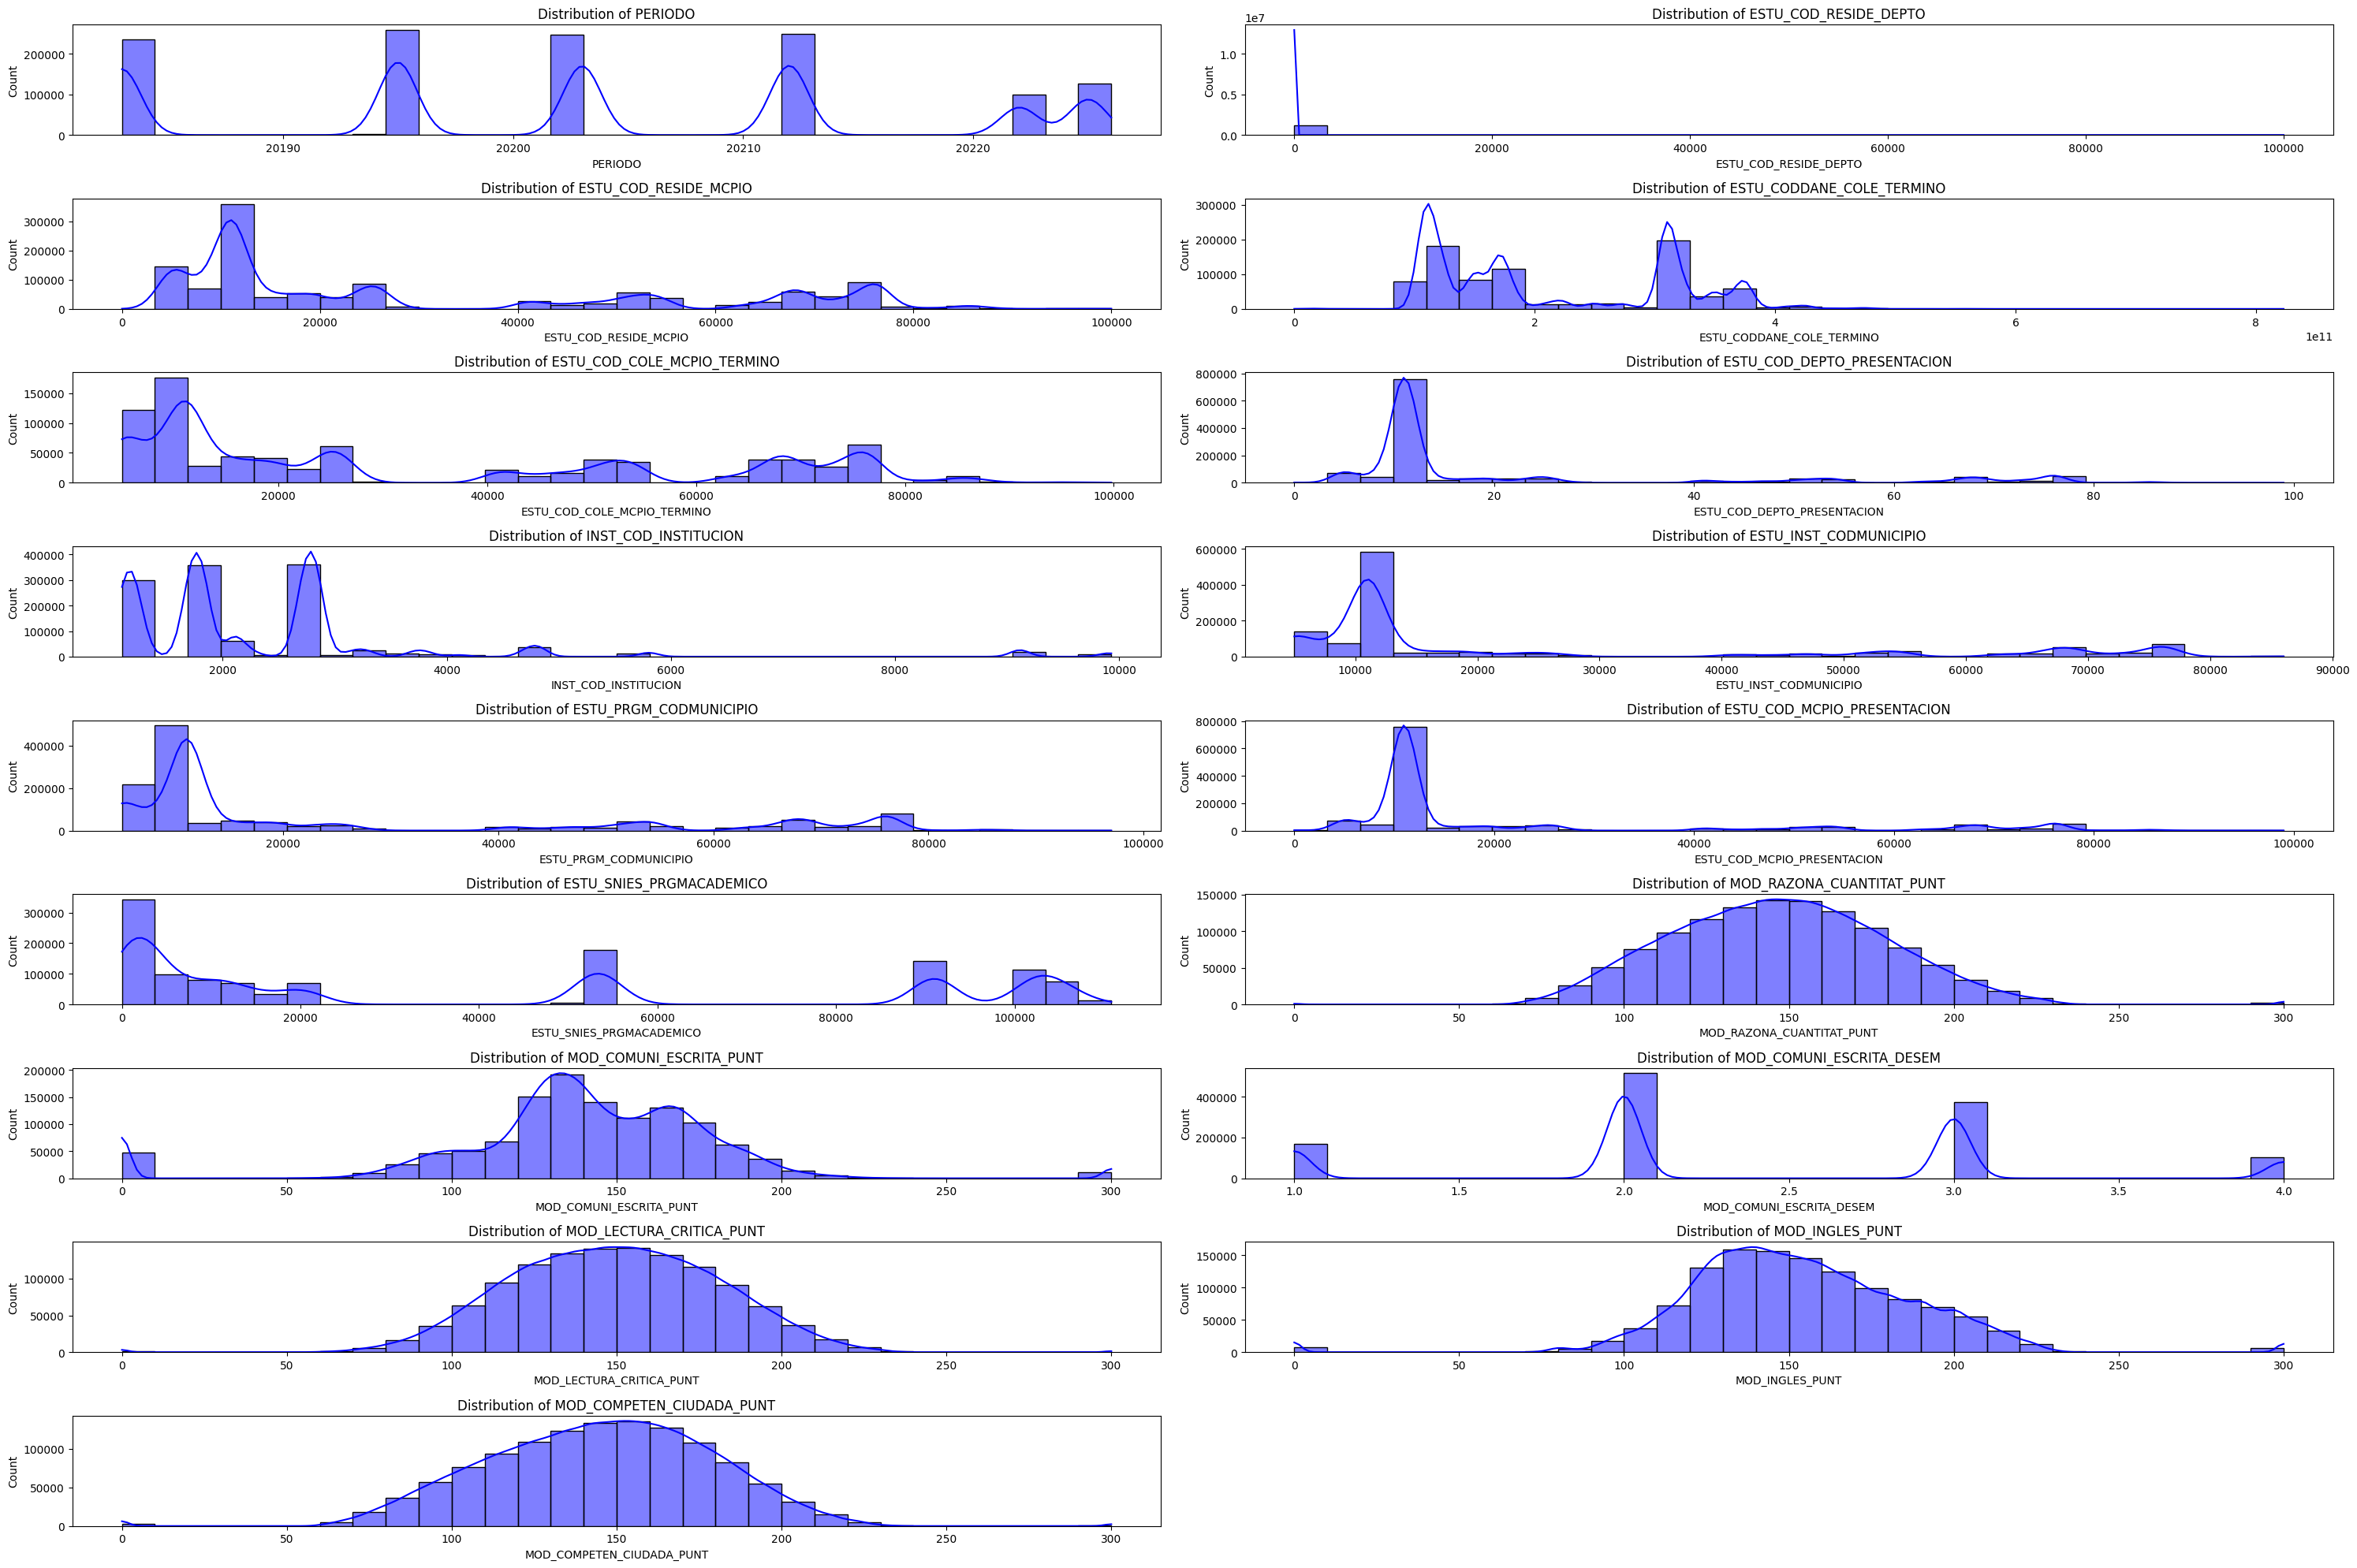

In [12]:
plt.figure(figsize=(30, 20))

# Calculate the number of rows and columns needed for subplots
num_cols = 2  # Keep 2 columns
num_rows = int(np.ceil(len(num_features) / num_cols))  # Calculate rows based on num_features

# Iterate through num_features and create subplots
for i, col in enumerate(num_features, 1):
    plt.subplot(num_rows, num_cols, i)  # Use calculated num_rows
    sns.histplot(df_0[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

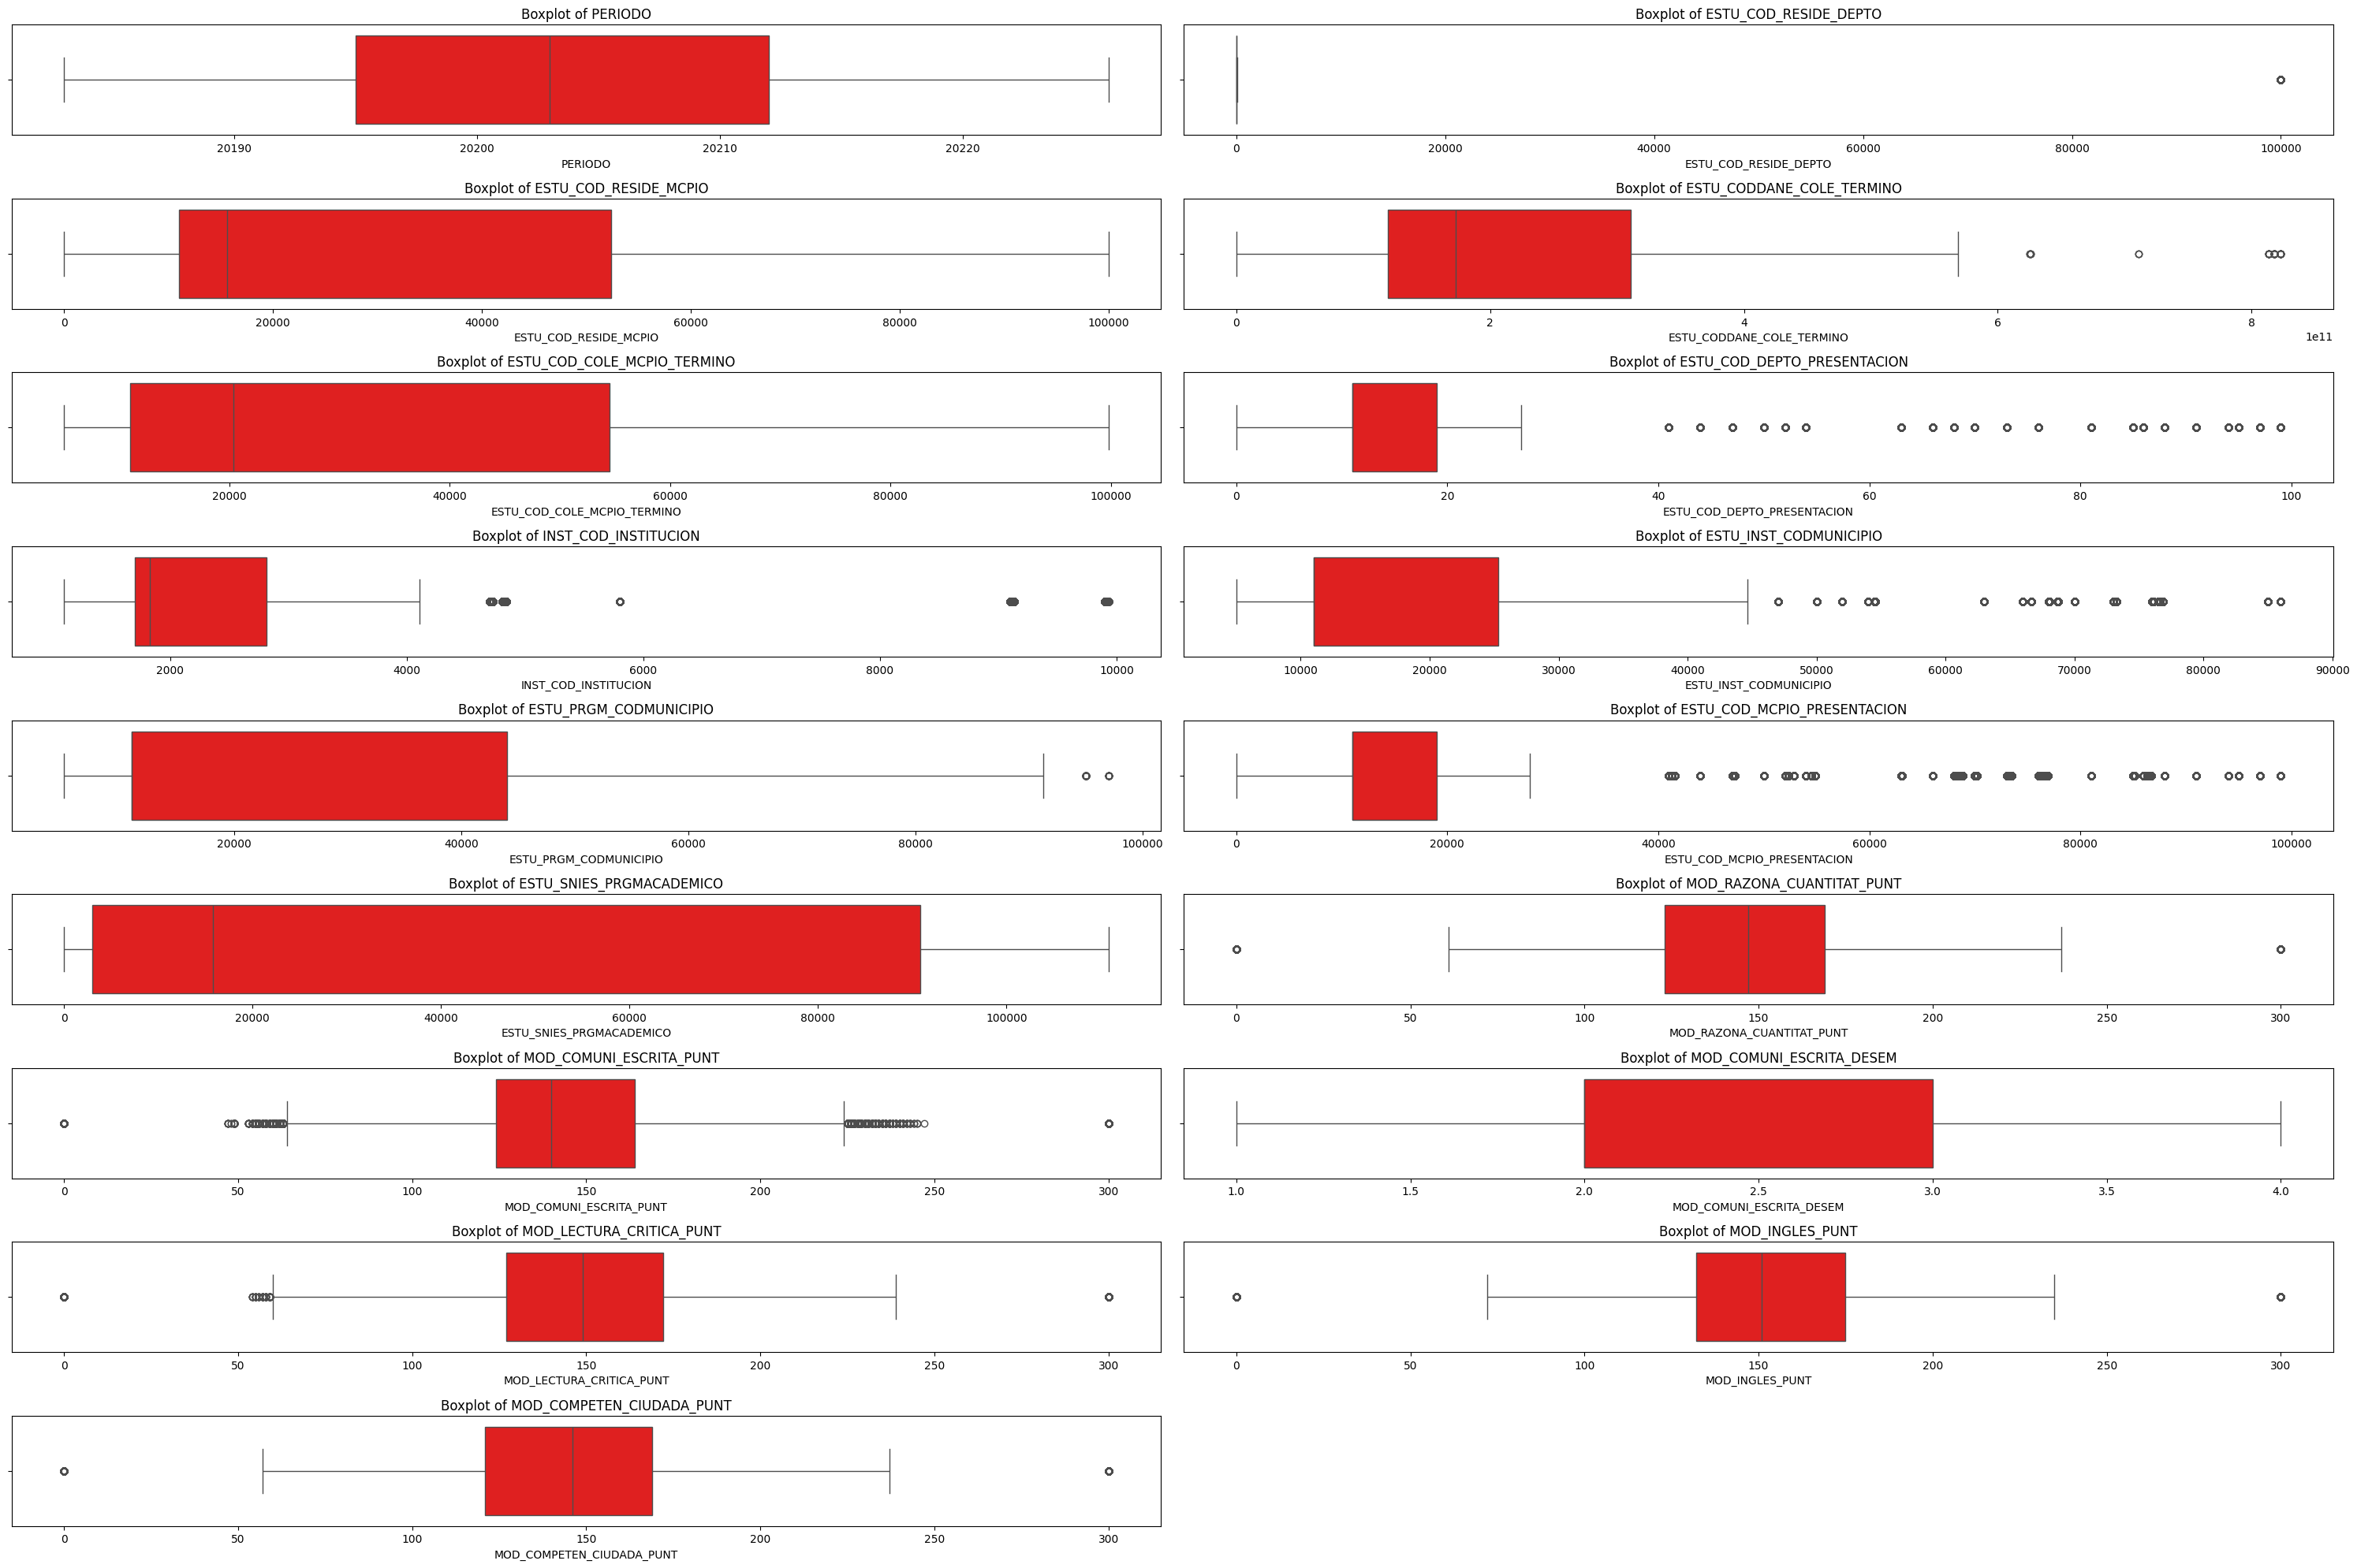

In [13]:
plt.figure(figsize=(30, 20))

for i, col in enumerate(num_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=df_0[col], color="red")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [14]:
from sklearn.impute import SimpleImputer

# Imputación de valores faltantes
# Imputación para numéricas: media
imp_num = SimpleImputer(strategy='mean')
df_0[num_features] = imp_num.fit_transform(df_0[num_features])

# Imputación para categóricas: moda
imp_cat = SimpleImputer(strategy='most_frequent')
df_0[cat_features] = imp_cat.fit_transform(df_0[cat_features])


In [15]:
from sklearn.preprocessing import OrdinalEncoder

# Instanciar el codificador
ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Aplicar codificación ordinal solo a las variables categóricas
df_0[cat_features] = ordinal_enc.fit_transform(df_0[cat_features])

In [16]:
print(df_0.isnull().sum().sum(), "valores faltantes restantes.")

0 valores faltantes restantes.


In [17]:
print("Tamaño final del dataset codificado:", df_0.shape)

Tamaño final del dataset codificado: (1217482, 57)


In [18]:
cols_puntajes = [
    "MOD_RAZONA_CUANTITAT_PUNT",
    "MOD_COMUNI_ESCRITA_PUNT",
    "MOD_LECTURA_CRITICA_PUNT",
    "MOD_INGLES_PUNT",
    "MOD_COMPETEN_CIUDADA_PUNT",
]

# Convertir a numérico
for col in cols_puntajes:
    df_0[col] = pd.to_numeric(df_0[col], errors='coerce')

# Crear puntaje promedio
df_0["PUNTAJE_TOTAL"] = df_0[cols_puntajes].mean(axis=1)


In [19]:
y = df_0["PUNTAJE_TOTAL"]

cols_a_excluir = [
    "PUNTAJE_TOTAL",
    "MOD_RAZONA_CUANTITAT_PUNT",
    "MOD_COMUNI_ESCRITA_PUNT",
    "MOD_LECTURA_CRITICA_PUNT",
    "MOD_INGLES_PUNT",
    "MOD_COMPETEN_CIUDADA_PUNT",
    "MOD_INGLES_DESEM",
    "ESTU_CONSECUTIVO",
    "ESTU_FECHANACIMIENTO",    
    "ESTU_DEPTO_RESIDE",
    "ESTU_MCPIO_RESIDE",
    "ESTU_DEPTO_PRESENTACION",
    "ESTU_MCPIO_PRESENTACION",


]

X = df_0.drop(columns=cols_a_excluir)

In [20]:
df_0.describe(include='all')

,PERIODO,ESTU_CONSECUTIVO,ESTU_TIPODOCUMENTO,ESTU_PAIS_RESIDE,ESTU_COD_RESIDE_DEPTO,ESTU_DEPTO_RESIDE,ESTU_COD_RESIDE_MCPIO,ESTU_MCPIO_RESIDE,ESTU_CODDANE_COLE_TERMINO,ESTU_COD_COLE_MCPIO_TERMINO,...,FAMI_EDUCACIONMADRE,INST_ORIGEN,MOD_RAZONA_CUANTITAT_PUNT,MOD_COMUNI_ESCRITA_PUNT,MOD_COMUNI_ESCRITA_DESEM,MOD_INGLES_DESEM,MOD_LECTURA_CRITICA_PUNT,MOD_INGLES_PUNT,MOD_COMPETEN_CIUDADA_PUNT,PUNTAJE_TOTAL
count,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06,...,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06,1.217482e+06
mean,2.020310e+04,6.078772e+05,1.902287e-02,2.006744e+01,6.783990e+01,1.713902e+01,3.005129e+04,3.680725e+02,2.160293e+11,3.310666e+04,...,6.617683e+00,1.323346e+00,1.467735e+02,1.391081e+02,2.350985e+00,1.997373e+00,1.494050e+02,1.535651e+02,1.448676e+02,1.467439e+02
std,1.369688e+01,3.503659e+05,3.353206e-01,1.916417e+00,1.945096e+03,1.569349e+01,2.586218e+04,3.023987e+02,8.166113e+10,2.162461e+04,...,3.249848e+00,1.387823e+00,3.227334e+01,4.204563e+01,8.152228e-01,1.098066e+00,3.114451e+01,3.366114e+01,3.385475e+01,2.534693e+01
min,2.018300e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.001000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.019500e+04,3.043702e+05,0.000000e+00,2.000000e+01,1.100000e+01,6.000000e+00,1.100100e+04,1.010000e+02,1.520010e+11,1.300100e+04,...,5.000000e+00,0.000000e+00,1.230000e+02,1.240000e+02,2.000000e+00,1.000000e+00,1.270000e+02,1.320000e+02,1.210000e+02,1.294000e+02
50%,2.020300e+04,6.087385e+05,0.000000e+00,2.000000e+01,1.500000e+01,8.000000e+00,1.575900e+04,2.510000e+02,2.160293e+11,3.310666e+04,...,8.000000e+00,1.000000e+00,1.470000e+02,1.400000e+02,2.000000e+00,2.000000e+00,1.490000e+02,1.510000e+02,1.460000e+02,1.460000e+02
75%,2.021200e+04,9.112798e+05,0.000000e+00,2.000000e+01,5.200000e+01,3.000000e+01,5.235600e+04,5.780000e+02,3.050010e+11,4.151800e+04,...,9.000000e+00,2.000000e+00,1.690000e+02,1.640000e+02,3.000000e+00,3.000000e+00,1.720000e+02,1.750000e+02,1.690000e+02,1.636000e+02
max,2.022600e+04,1.212455e+06,8.000000e+00,8.500000e+01,9.999900e+04,5.000000e+01,9.999900e+04,1.043000e+03,8.230011e+11,9.977300e+04,...,1.100000e+01,5.000000e+00,3.000000e+02,3.000000e+02,4.000000e+00,4.000000e+00,3.000000e+02,3.000000e+02,3.000000e+02,2.782000e+02


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
usage_total, stop_total, thread_total = start_monitor()
total_start_time = time.time()

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=3,
)


In [24]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=3, random_state=42)

In [25]:
total_end_time = time.time()
stop_monitor(stop_total, thread_total)

In [26]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [27]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predicción
y_pred = rf_model.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f" MAE: {mae:.2f}")

RMSE: 16.40
R²: 0.5804
 MAE: 12.82


In [28]:
usage_rf, stop_rf, thread_rf = start_monitor()
rf_start_time = time.time()

# Ajustar el modelo (fit)
rf_model.fit(X_train, y_train)

rf_end_time = time.time()
stop_monitor(stop_rf, thread_rf)

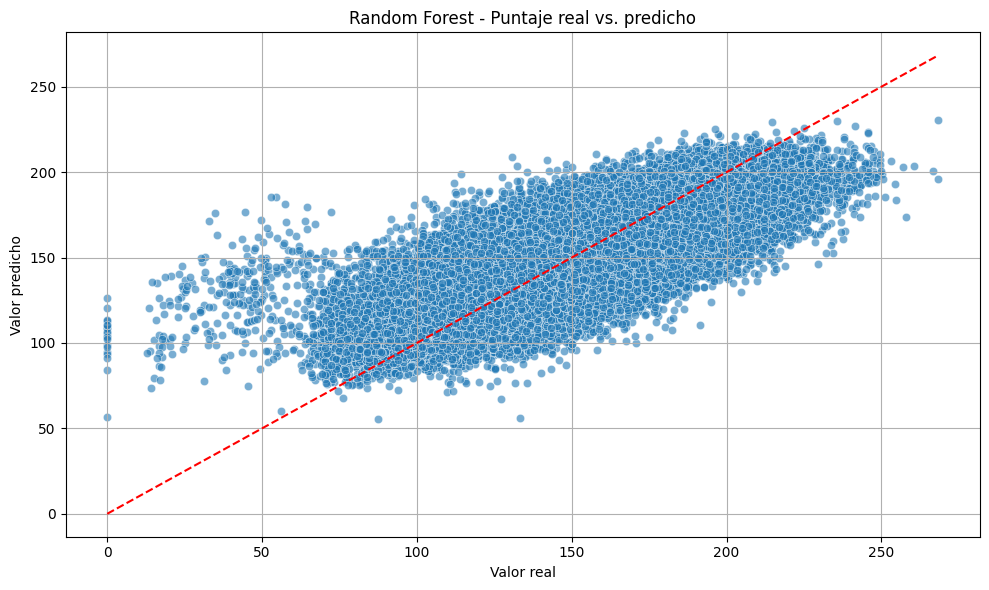

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

# Línea ideal: donde real = predicho
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# Etiquetas y título
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Random Forest - Puntaje real vs. predicho")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\leand\AppData\Local\Temp\ipykernel_37784\2876635151.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importancia", y="Variable", data=importances_df.head(15), palette="viridis")


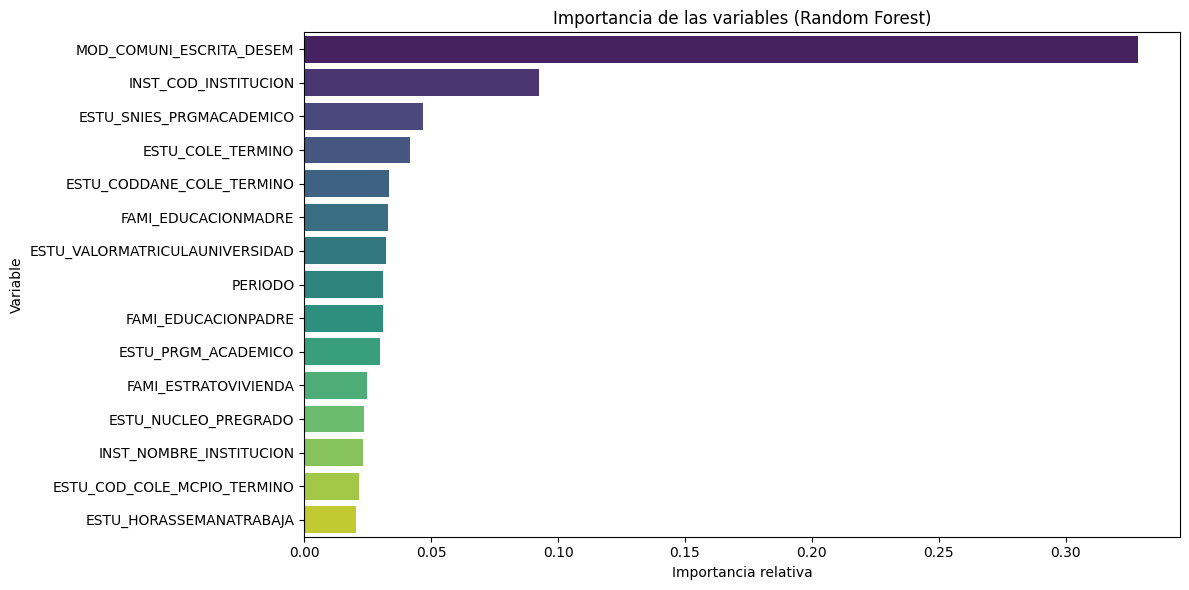

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extraer importancias desde el modelo real
importances = rf_model.feature_importances_
features = X_train.columns

# Crear DataFrame
importances_df = pd.DataFrame({
    "Variable": features,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False)

# Graficar las 15 más importantes
plt.figure(figsize=(12, 6))
sns.barplot(x="Importancia", y="Variable", data=importances_df.head(15), palette="viridis")
plt.title("Importancia de las variables (Random Forest)")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


C:\Users\leand\AppData\Local\Temp\ipykernel_37784\1385401167.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_0, x='FAMI_ESTRATOVIVIENDA', y='PUNTAJE_TOTAL', palette='viridis')


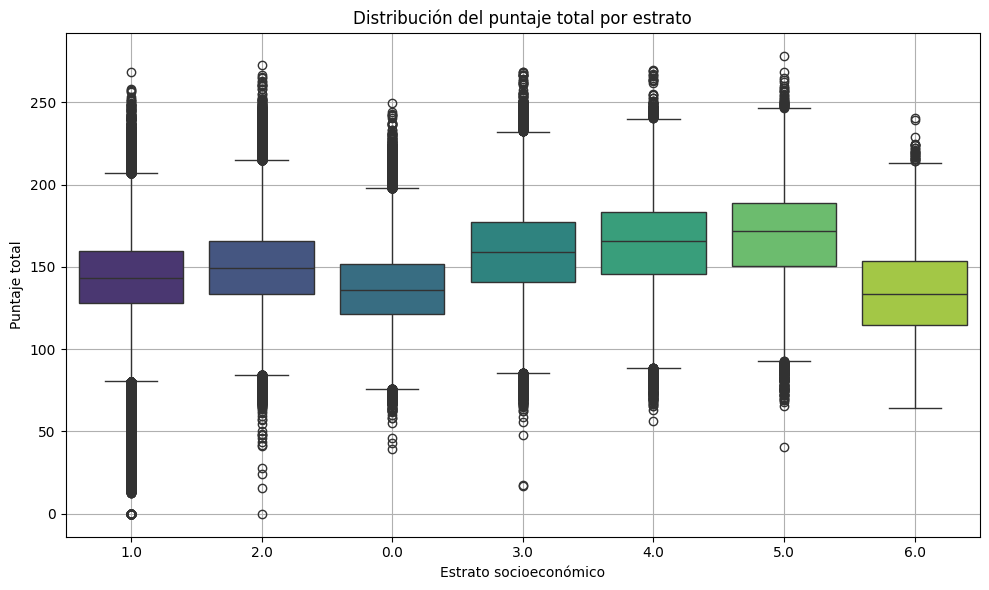

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

df_0['FAMI_ESTRATOVIVIENDA'] = df_0['FAMI_ESTRATOVIVIENDA'].astype(str)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_0, x='FAMI_ESTRATOVIVIENDA', y='PUNTAJE_TOTAL', palette='viridis')
plt.title("Distribución del puntaje total por estrato")
plt.xlabel("Estrato socioeconómico")
plt.ylabel("Puntaje total")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\leand\AppData\Local\Temp\ipykernel_37784\646410959.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x=var, y="PUNTAJE_TOTAL", palette="viridis")


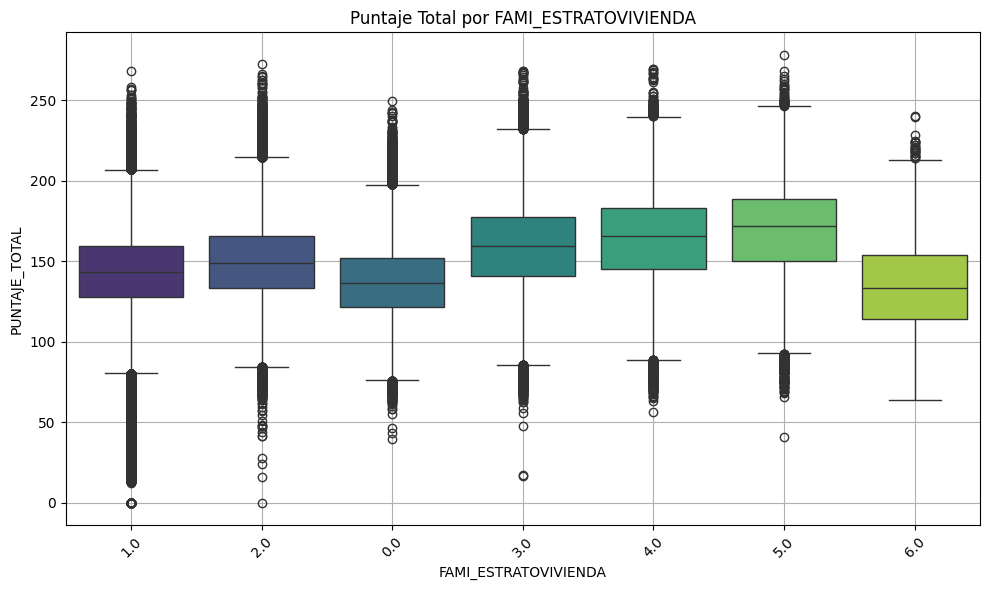

C:\Users\leand\AppData\Local\Temp\ipykernel_37784\646410959.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x=var, y="PUNTAJE_TOTAL", palette="viridis")


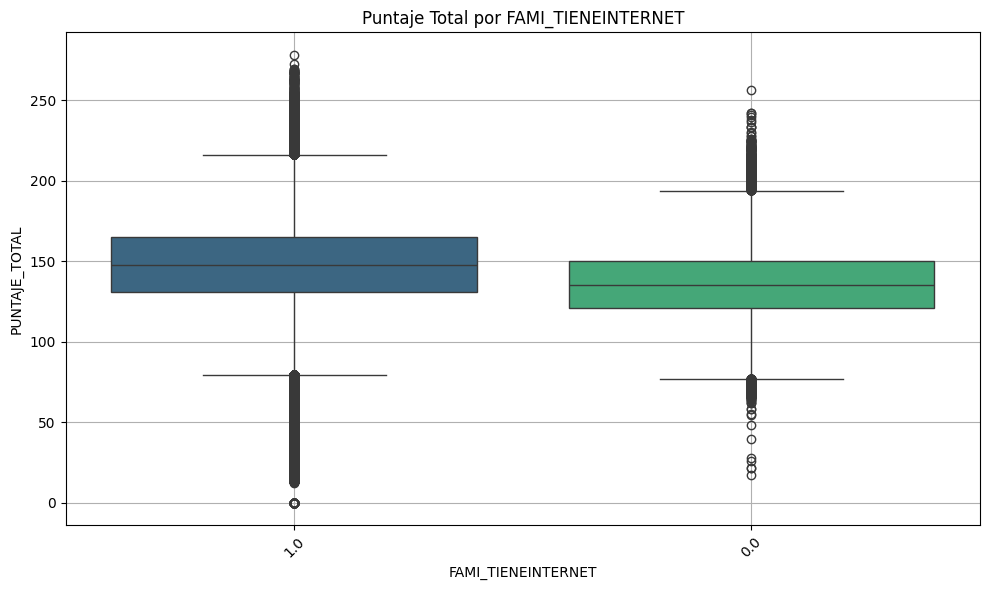

C:\Users\leand\AppData\Local\Temp\ipykernel_37784\646410959.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x=var, y="PUNTAJE_TOTAL", palette="viridis")


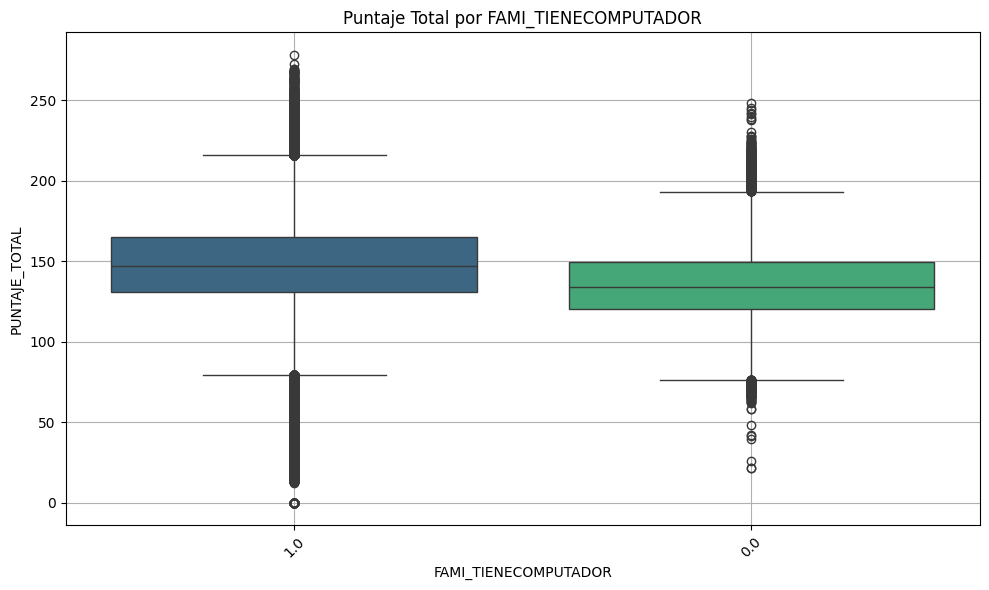

C:\Users\leand\AppData\Local\Temp\ipykernel_37784\646410959.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x=var, y="PUNTAJE_TOTAL", palette="viridis")


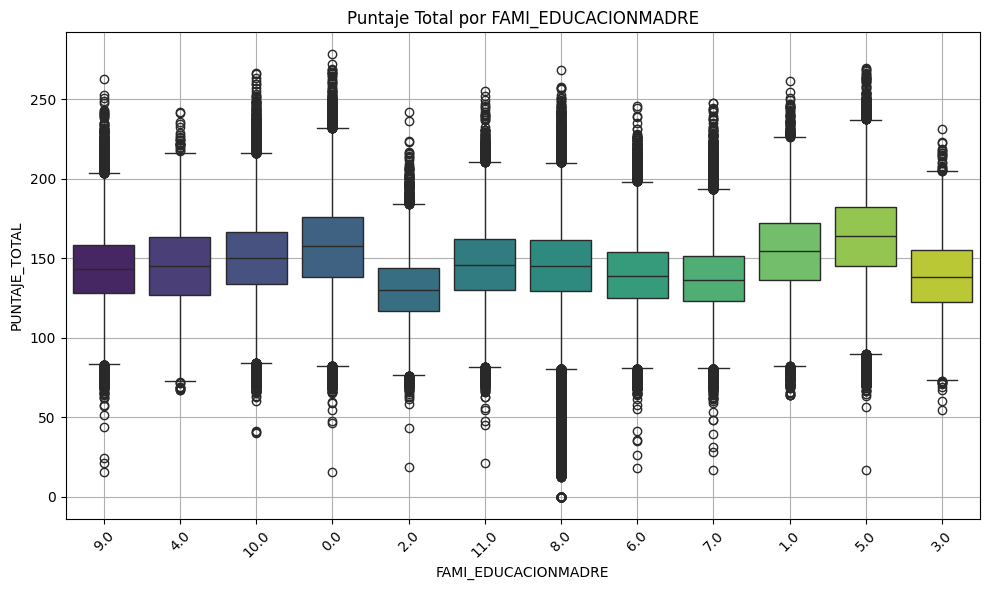

C:\Users\leand\AppData\Local\Temp\ipykernel_37784\646410959.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x=var, y="PUNTAJE_TOTAL", palette="viridis")


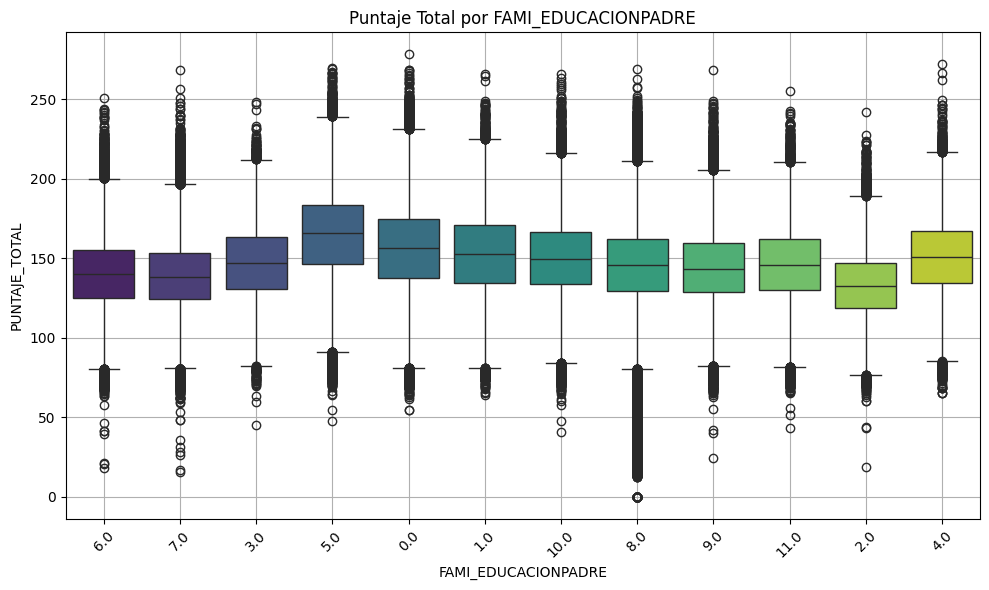

                                      mean        std    count
Variable             Categoría                                
FAMI_ESTRATOVIVIENDA 5.0        168.802873  28.861765    21709
                     4.0        163.932498  27.545074    40673
                     3.0        158.635159  26.254818   112573
                     2.0        149.618132  23.967437   366054
                     1.0        143.464027  24.091226   464925
                     0.0        137.145763  22.562664   205875
                     6.0        134.783255  27.961231     5673
FAMI_TIENEINTERNET   1.0        148.058557  25.394417  1088343
                     0.0        135.664261  22.019091   129139
FAMI_TIENECOMPUTADOR 1.0        147.866048  25.362619  1110902
                     0.0        135.047412  22.005623   106580
FAMI_EDUCACIONMADRE  5.0        163.144905  26.930644    82756
                     0.0        156.953811  26.585682   152001
                     1.0        153.998692  25.866143  

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegura que MOD_RAZONA_CUANTITAT_PUNT esté en formato numérico
df_0['PUNTAJE_TOTAL'] = pd.to_numeric(df_0['PUNTAJE_TOTAL'], errors='coerce')

# Lista de variables socioeconómicas a analizar
socio_vars = [
    "FAMI_ESTRATOVIVIENDA",
    "FAMI_TIENEINTERNET",
    "FAMI_TIENECOMPUTADOR",
    "FAMI_EDUCACIONMADRE",
    "FAMI_EDUCACIONPADRE"
]

# Crear tabla resumen con media, desviación estándar y cantidad
summary_tables = {}
for var in socio_vars:
    if var in df_0.columns:
        # Asegurar que sea string para agrupar
        df_0[var] = df_0[var].astype(str)

        # Eliminar nulos solo para análisis puntual
        df_clean = df_0[[var, "PUNTAJE_TOTAL"]].dropna()

        # Crear resumen estadístico por grupo
        summary = df_clean.groupby(var)["PUNTAJE_TOTAL"].agg(['mean', 'std', 'count'])
        summary = summary.sort_values('mean', ascending=False)
        summary_tables[var] = summary

        # Generar gráfico boxplot para la variable actual
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df_clean, x=var, y="PUNTAJE_TOTAL", palette="viridis")
        plt.title(f"Puntaje Total por {var}")
        plt.xlabel(var)
        plt.ylabel("PUNTAJE_TOTAL")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Unir y mostrar todas las tablas resumen (puedes exportar si deseas)
df_resumen = pd.concat(summary_tables, names=["Variable", "Categoría"])
print(df_resumen)



C:\Users\leand\AppData\Local\Temp\ipykernel_37784\210339052.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_inst, x='INST_ORIGEN', y='PUNTAJE_TOTAL', palette="coolwarm")


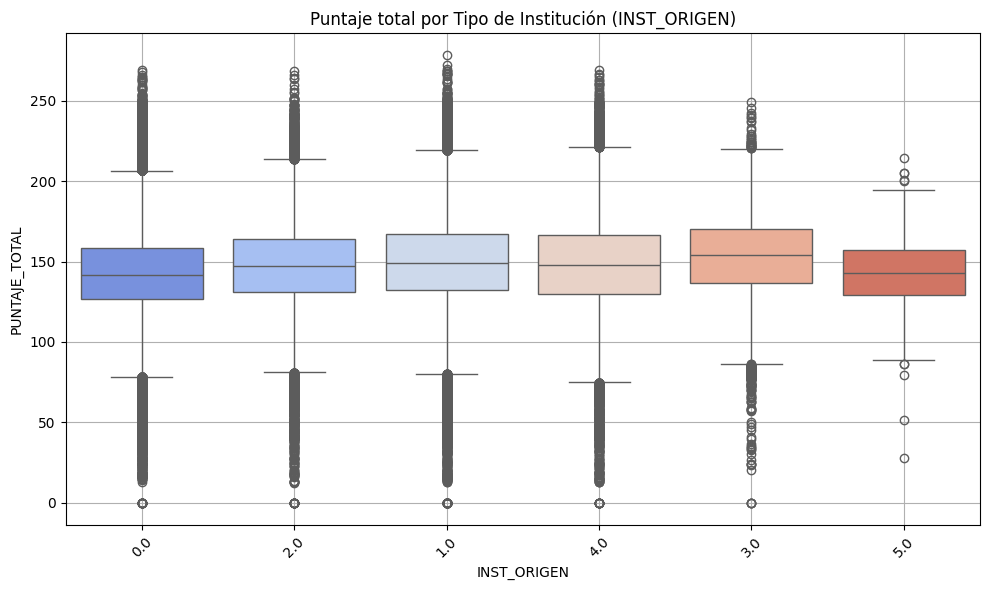

                   mean        std   count
INST_ORIGEN                               
3.0          152.524055  24.327589   26285
1.0          149.605265  25.546310  382810
4.0          148.075105  26.606846  193215
2.0          147.400020  24.446088  186150
0.0          142.952814  24.536525  428157
5.0          142.730686  21.878355     865


In [33]:

df_0['INST_ORIGEN'] = df_0['INST_ORIGEN'].astype(str)

# Eliminar nulos
df_inst = df_0[['INST_ORIGEN', 'PUNTAJE_TOTAL']].dropna()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_inst, x='INST_ORIGEN', y='PUNTAJE_TOTAL', palette="coolwarm")
plt.title("Puntaje total por Tipo de Institución (INST_ORIGEN)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Tabla resumen
summary_inst = df_inst.groupby('INST_ORIGEN')['PUNTAJE_TOTAL'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)
print(summary_inst)


In [34]:
total_end_time = time.time()
stop_monitor(stop_total, thread_total)

In [35]:
##########################################
# RESULTADOS → TODO EL PIPELINE
##########################################

cpu_avg_total = np.mean(usage_total['cpu'])
mem_avg_total = np.mean(usage_total['mem'])
total_time = total_end_time - total_start_time
vel_total = mem_avg_total / total_time if total_time > 0 else 0

print("📌 === RESUMEN DEL PIPELINE COMPLETO ===")
print(f"⏰ Tiempo total: {total_time:.2f} segundos")
print(f"🧠 CPU promedio: {cpu_avg_total:.2f}%")
print(f"📦 Memoria promedio: {mem_avg_total:.2f} MB")
print(f"🚀 Velocidad de procesamiento pipeline: {vel_total:.2f} MB/s")

📌 === RESUMEN DEL PIPELINE COMPLETO ===
⏰ Tiempo total: 932.18 segundos
🧠 CPU promedio: 25.66%
📦 Memoria promedio: 14087.97 MB
🚀 Velocidad de procesamiento pipeline: 15.11 MB/s


In [36]:
##########################################
# RESULTADOS → SOLO RANDOM FOREST FIT
##########################################


cpu_avg_rf = np.mean(usage_rf['cpu'])
mem_avg_rf = np.mean(usage_rf['mem'])
rf_time = rf_end_time - rf_start_time
vel_rf = mem_avg_rf / rf_time if rf_time > 0 else 0

print("\n📌 === SOLO RANDOM FOREST (ajuste) ===")
print(f"⏰ Tiempo RF: {rf_time:.2f} segundos")
print(f"🧠 CPU promedio RF: {cpu_avg_rf:.2f}%")
print(f"📦 Memoria promedio RF: {mem_avg_rf:.2f} MB")
print(f"🚀 Velocidad de procesamiento RF: {vel_rf:.2f} MB/s")
print(f"📏 RMSE: {rmse:.2f}")
print(f"📏 R2: {r2:.4f}")
print(f"📏 MAE: {mae:.2f}")


📌 === SOLO RANDOM FOREST (ajuste) ===
⏰ Tiempo RF: 441.58 segundos
🧠 CPU promedio RF: 24.36%
📦 Memoria promedio RF: 11877.87 MB
🚀 Velocidad de procesamiento RF: 26.90 MB/s
📏 RMSE: 16.40
📏 R2: 0.5804
📏 MAE: 12.82
